In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#filepath of the road-accidents dataset and miles driven dataset
file_miles_driven= "C:/Users/HP/Downloads/miles-driven.csv"
file_road_accidents= "C:/Users/HP/Downloads/road-accidents.csv"

In [3]:
#creating datadrame
miles_driven_data = pd.read_csv(file_miles_driven, delimiter='|')
road_accidents_data = pd.read_csv(file_road_accidents, delimiter='|', skiprows=lambda x: x in range(0,9))

#### Textual and a graphical summary of the data

In [4]:
#summary statistics of the road_accidents_data dataframe
road_accidents_data.describe()

,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time
count,51.000000,51.000000,51.000000,51.00000
mean,15.790196,31.725490,30.686275,88.72549
std,4.122002,9.633438,5.132213,6.96011
min,5.900000,13.000000,16.000000,76.00000
25%,12.750000,23.000000,28.000000,83.50000
50%,15.600000,34.000000,30.000000,88.00000
75%,18.500000,38.000000,33.000000,95.00000
max,23.900000,54.000000,44.000000,100.00000


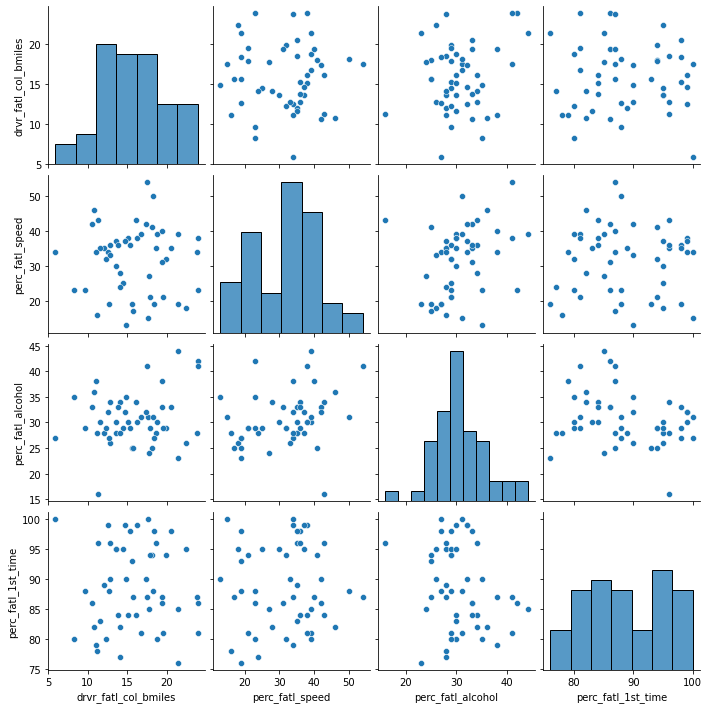

In [5]:
#using "scatterplot matrix"(seaborn "pairplot") to get an idea of pairwise relationship between all the columns of the data
sns.pairplot(road_accidents_data)

### Note:
* From above plots we can see some potentially interesting relationship between the target variable(drvr_fatl_col_bmiles) and the three features

* But to get the more quantitative description we are going to compute Pearson Correlation Coefficient Matrix

#### Quantifying the association of features and accidents

In [6]:
#Pearson Correlation Coefficient Matrix
road_accidents_data.corr()

,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time
drvr_fatl_col_bmiles,1.000000,-0.029080,0.199426,-0.017942
perc_fatl_speed,-0.029080,1.000000,0.286244,0.014066
perc_fatl_alcohol,0.199426,0.286244,1.000000,-0.245455
perc_fatl_1st_time,-0.017942,0.014066,-0.245455,1.000000


<AxesSubplot:>

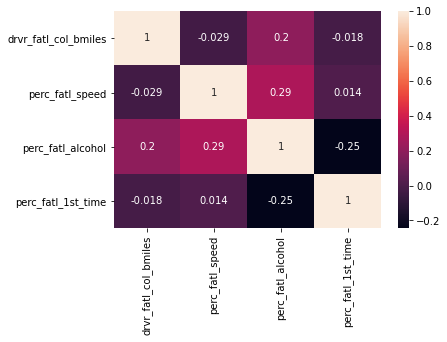

In [7]:
#Using heatmap to visualize the matrix better
sns.heatmap(road_accidents_data.corr(), annot=True)

### Note:
* From the correlation table as well as the Heatmap we can see that the amount of fatal accidents is most strongly correlated with alcohol consumption (first row)

* Although the correlation coefficient between 'drvr_fatl_col_bmiles' and 'perc_fatl_alcohol' is 0.2 which by convention is considered 'weak', i.e., weakly related but here except alcohol consumption other two features are very poorly related to the target variable.

* Also in addition, we can see that some of the features are correlated with each other, for instance, speeding and alcohol consumption are positively correlated.

#### Multivariate linear regression model

In [8]:
#Dividing the dataframe into target variable y and feature variables X to fit a Multivariate Linear Regression Model
X = road_accidents_data[['perc_fatl_speed', 'perc_fatl_alcohol', 'perc_fatl_1st_time']]
X = X.to_numpy()
y = road_accidents_data.drvr_fatl_col_bmiles
y = y.to_numpy()

In [9]:
#Splitting into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [10]:
#Fitting the model on training data
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [11]:
##Calculating the Intercept and Coefficient
print(regressor.intercept_)
print(regressor.coef_)

17.96826486062231
[-0.03130744  0.02052854 -0.0215321 ]


### Note:
* We can see that the regression coefficients are slightly different from correlation coefficients
* The reason for this is that the multiple regression computes the association of a feature with an outcome, given the association with all other features, which is not accounted for when calculating the correlation coefficients.

#### PCA on standardized data

In [12]:
#Feature scaling
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
scaled_X= scaler.fit_transform(X)

In [13]:
#Applying PCA on scaled features
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_scaled_X = pca.fit_transform(scaled_X)

#### Visualizing the first two principal components

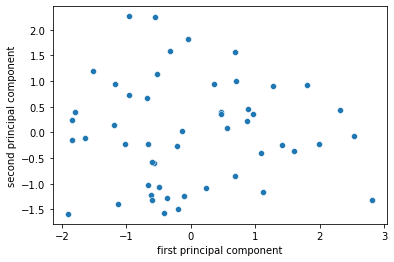

In [14]:
#visualizing first two principal components using scatterplot 
sns.scatterplot(x = pca_scaled_X[:,0], y = pca_scaled_X[:,1])
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

### Note:
* From the above plot we can see that it is not entirely clear from the PCA scatter plot how many groups in which the states cluster.
* So we are going to use KMeans clustering by creating a scree plot and finding the "elbow", which is an indication of when the addition of more clusters does not add much explanatory power.

#### Finding elbow in  the scree plot

In [15]:
#KMeans clustering
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

In [16]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

for k in K:
	# Building and fitting the model
	kmeanModel = KMeans(n_clusters=k)
	kmeanModel.fit(scaled_X)

	distortions.append(sum(np.min(cdist(scaled_X, kmeanModel.cluster_centers_,'euclidean'), axis=1)) / scaled_X.shape[0])
	inertias.append(kmeanModel.inertia_)

	mapping1[k] = sum(np.min(cdist(scaled_X, kmeanModel.cluster_centers_,'euclidean'), axis=1)) / scaled_X.shape[0]
	mapping2[k] = kmeanModel.inertia_


C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


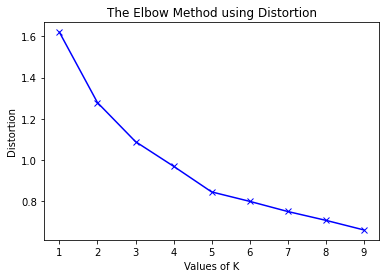

In [17]:
#scree plot using distortions
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

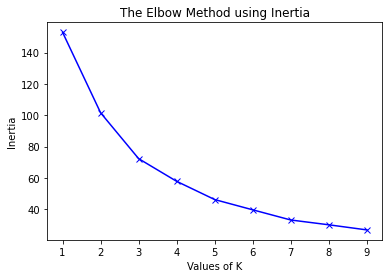

In [18]:
#scree plot using in inertias
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

### Note:
* Since there wasn't a clear elbow in the scree plot, assigning the states to either two or three clusters is a reasonable choice, and we will resume our analysis using three clusters.

#### KMeans to visualize clusters in the PCA scatter plot

In [19]:
dataset = pd.DataFrame({'Column1': pca_scaled_X[:, 0], 'Column2': pca_scaled_X[:, 1]})

In [20]:
#dividing the data into three clusters
kmeans = KMeans(n_clusters=3)
dataset["Cluster"] = kmeans.fit_predict(scaled_X)
dataset["Cluster"] = dataset["Cluster"].astype("category")

In [21]:
dataset.head(10)

,Column1,Column2,Cluster
0,0.884639,0.464211,2
1,-0.625299,-1.220247,1
2,-0.671696,-1.027863,1
3,-1.839546,0.239910,1
4,-0.211743,-0.256667,1
5,-0.493905,-1.054144,1
6,1.988056,-0.226978,2
7,-0.419847,-1.560808,1
8,-1.130991,-1.401442,1
9,-1.184444,0.148770,1


<AxesSubplot:xlabel='Column1', ylabel='Column2'>

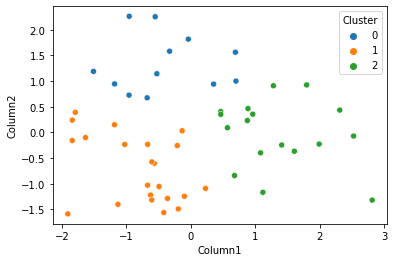

In [22]:
#scatterplot showing division of data into three clusters
sns.scatterplot(x="Column1", y="Column2", hue="Cluster", data=dataset)

### Note:
* Each point in the above scatterplot represents a state and we can see that these states are grouped into three clusters.

* Now we are going to see below which states belongs to which cluster.

In [23]:
#adding cluster column to road_accidents_data w.r.t state column
road_accidents_data['Cluster'] = dataset.Cluster

In [37]:
road_accidents_data.head()

,state,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time,Cluster
0,Alabama,18.8,39,30,80,2
1,Alaska,18.1,41,25,94,1
2,Arizona,18.6,35,28,96,1
3,Arkansas,22.4,18,26,95,1
4,California,12.0,35,28,89,1


In [25]:
#List of States in Different Clusters
for i in range(0,3):
    print(f'States in Cluster {i}:', road_accidents_data[road_accidents_data.Cluster == i].state.values, '\n')

States in Cluster 0: ['Iowa' 'Kansas' 'Kentucky' 'Massachusetts' 'Michigan' 'Minnesota'
 'Nebraska' 'New Jersey' 'New York' 'Ohio' 'Tennessee' 'Virginia'] 

States in Cluster 1: ['Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado' 'Delaware'
 'District of Columbia' 'Florida' 'Georgia' 'Idaho' 'Illinois' 'Indiana'
 'Louisiana' 'Maryland' 'Mississippi' 'Nevada' 'New Mexico' 'Oklahoma'
 'Oregon' 'Utah' 'Vermont' 'West Virginia'] 

States in Cluster 2: ['Alabama' 'Connecticut' 'Hawaii' 'Maine' 'Missouri' 'Montana'
 'New Hampshire' 'North Carolina' 'North Dakota' 'Pennsylvania'
 'Rhode Island' 'South Carolina' 'South Dakota' 'Texas' 'Washington'
 'Wisconsin' 'Wyoming'] 



### Note:
* Now we are going to see how the three clusters are different in terms of the three features that we used for clustering.

#### Visualizing the feature differences between the clusters

In [26]:
grouped_by_cluster = road_accidents_data.groupby('Cluster')

In [27]:
#summary statistics of the three clusters w.r.t 'perc_fatl_speed' feature
grouped_by_cluster.perc_fatl_speed.describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,12.0,21.833333,5.457827,13.0,18.50,22.0,24.75,32.0
1,22.0,31.227273,7.999594,15.0,26.25,34.0,36.00,43.0
2,17.0,39.352941,7.070548,23.0,36.00,39.0,42.00,54.0


In [28]:
#summary statistics of the three clusters w.r.t 'perc_fatl_alcohol' feature
grouped_by_cluster.perc_fatl_alcohol.describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,12.0,28.833333,4.041452,23.0,26.5,28.5,30.25,35.0
1,22.0,28.272727,3.679827,16.0,27.0,28.5,30.00,34.0
2,17.0,35.117647,4.675499,30.0,31.0,33.0,38.00,44.0


In [29]:
#summary statistics of the three clusters w.r.t 'perc_fatl_1st_time' feature
grouped_by_cluster.perc_fatl_1st_time.describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,12.0,82.666667,4.773665,76.0,79.5,81.5,87.25,90.0
1,22.0,95.454545,3.487765,87.0,94.0,95.5,98.00,100.0
2,17.0,84.294118,3.015889,79.0,82.0,84.0,86.00,90.0


In [30]:
#summary statistics of the three clusters w.r.t 'drvr_fatl_col_bmiles' feature
grouped_by_cluster.drvr_fatl_col_bmiles.describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,12.0,14.291667,3.903019,8.2,12.025,14.10,16.225,21.4
1,22.0,15.818182,4.074384,5.9,13.000,15.45,18.325,23.8
2,17.0,16.811765,4.247482,10.6,13.800,17.40,19.400,23.9


#### Computing the number of accidents within each cluster

* Adding the miles_driven_data to the road_accidents_data to get the total number road accidents in each state

In [31]:
#merging the two datasets
total_road_accidents_data = pd.merge(road_accidents_data, miles_driven_data, on='state')

In [32]:
total_road_accidents_data.head()

,state,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time,Cluster,million_miles_annually
0,Alabama,18.8,39,30,80,2,64914
1,Alaska,18.1,41,25,94,1,4593
2,Arizona,18.6,35,28,96,1,59575
3,Arkansas,22.4,18,26,95,1,32953
4,California,12.0,35,28,89,1,320784


In [33]:
#calculating total number of fatal accidents in each state 
total_road_accidents_data["total_number_fatl_accidents"] = (total_road_accidents_data.drvr_fatl_col_bmiles * total_road_accidents_data.million_miles_annually) / 1000

In [34]:
total_road_accidents_data.head()

,state,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time,Cluster,million_miles_annually,total_number_fatl_accidents
0,Alabama,18.8,39,30,80,2,64914,1220.3832
1,Alaska,18.1,41,25,94,1,4593,83.1333
2,Arizona,18.6,35,28,96,1,59575,1108.0950
3,Arkansas,22.4,18,26,95,1,32953,738.1472
4,California,12.0,35,28,89,1,320784,3849.4080


<AxesSubplot:xlabel='total_number_fatl_accidents', ylabel='Cluster'>

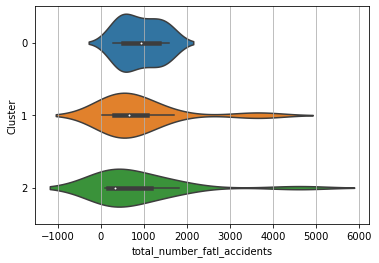

In [35]:
#creating violin plot to see the variation in total number of fatal accidents in each state in each cluster.
plt.grid()
sns.violinplot(x=total_road_accidents_data["total_number_fatl_accidents"], y=total_road_accidents_data.Cluster)

In [36]:
#calulating total number of accidents in each cluster
total_road_accidents_data.groupby('Cluster').total_number_fatl_accidents.sum()

Cluster
0    11044.6244
1    19764.3291
2    14826.2569
Name: total_number_fatl_accidents, dtype: float64

#### Conclusion

* Although there is no obvious correct choice regarding which cluster is the most important to focus on. But, if i have to choose one I would put more focus on "cluster 1" because we can see from the above analysis that total number of fatal accidents is maximum for cluster 1 and also number of states is maximum in this group.